In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def generate_checkerboard_samples(N, size):
    # Initialize a tensor to hold the N samples of checkerboard patterns
    samples = torch.zeros((N, size, size, 3))  # 3 for RGB channels

    for i in range(N):
        # Generate random colors for the checkerboard
        color1 = torch.rand(3, dtype=torch.float32)  # Color for one set of squares
        color2 = torch.rand(3, dtype=torch.float32)  # Color for the other set of squares

        for x in range(size):
            for y in range(size):
                if (x + y) % 2 == 0:
                    samples[i, x, y] = color1
                else:
                    samples[i, x, y] = color2

    return samples


samples = generate_checkerboard_samples(2, 4)
print(samples[1])

tensor([[[0.7301, 0.8878, 0.4937],
         [0.9274, 0.4742, 0.5200],
         [0.7301, 0.8878, 0.4937],
         [0.9274, 0.4742, 0.5200]],

        [[0.9274, 0.4742, 0.5200],
         [0.7301, 0.8878, 0.4937],
         [0.9274, 0.4742, 0.5200],
         [0.7301, 0.8878, 0.4937]],

        [[0.7301, 0.8878, 0.4937],
         [0.9274, 0.4742, 0.5200],
         [0.7301, 0.8878, 0.4937],
         [0.9274, 0.4742, 0.5200]],

        [[0.9274, 0.4742, 0.5200],
         [0.7301, 0.8878, 0.4937],
         [0.9274, 0.4742, 0.5200],
         [0.7301, 0.8878, 0.4937]]])


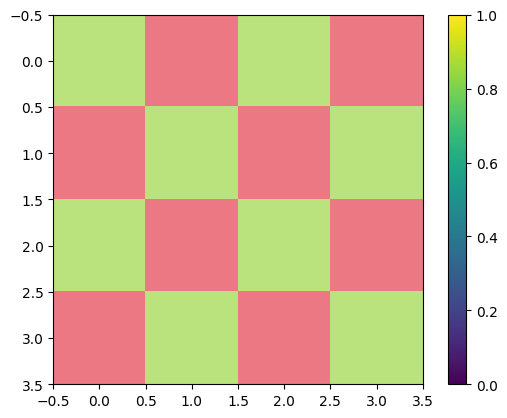

In [2]:
def visualize(matrix : np.ndarray, title : str = ""):
    plt.imshow(matrix, interpolation='none', vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()
    plt.show()

visualize(samples[1])

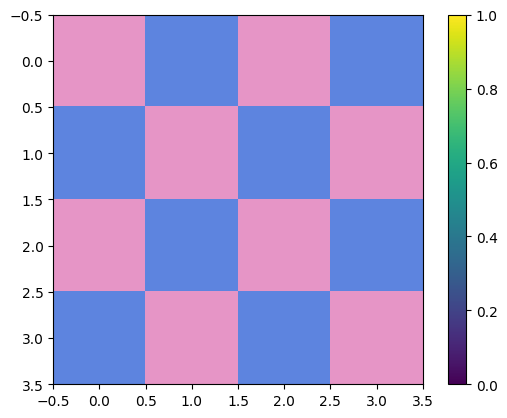

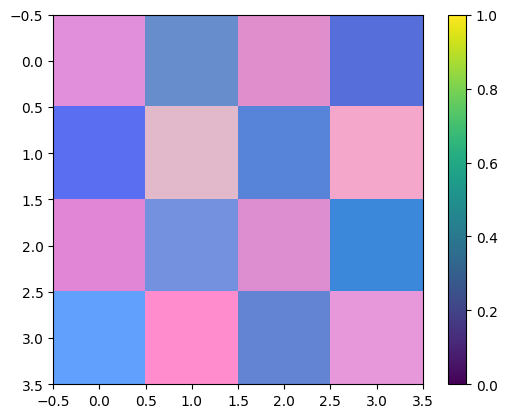

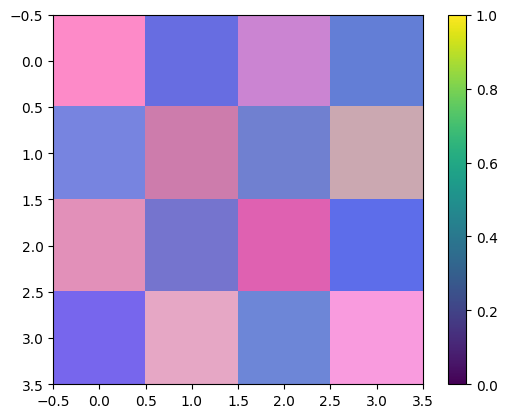

Mean of slow: 0.6812098622322083
Variance of slow: 0.044704556465148926
Mean of fast: 0.6593451499938965
Variance of fast: 0.03794897347688675


In [3]:
import copy

def do_noise_skip(input : torch.tensor, t : int, beta_t : float):
    ret = copy.deepcopy(input)

    for i in range(t):
        ret = ret * np.sqrt(1 - beta_t) + torch.randn(input.shape) * np.sqrt(beta_t)

    ret = torch.clamp(ret, 0, 1) # do they do this in the original paper?
    return ret

def do_fast_noise_skip(input : torch.tensor, t : int, beta_t : float):
    # might be able to get further optimized

    alpha_t_cum = 1
    for i in range(1, t+1):
        alpha_t_cum *= (1 - beta_t)

    standard_normal = torch.randn(input.shape)
    noise = standard_normal * np.sqrt(1- alpha_t_cum)

    input_with_noise = input + noise

    input_with_noise = torch.clamp(input_with_noise, 0, 1) # do they do this in the original paper?

    return input_with_noise, standard_normal

ground_truth = generate_checkerboard_samples(1, 4)

beta_t_temp = 0.0008
t = 5
tmp = copy.deepcopy(ground_truth[0])
visualize(tmp)

slow = do_noise_skip(tmp, t, beta_t_temp)
fast, _ = do_fast_noise_skip(tmp, t, beta_t_temp)
visualize(slow)
visualize(fast)

mean_slow = torch.mean(slow)
variance_slow = torch.var(slow)
print(f"Mean of slow: {mean_slow.item()}")
print(f"Variance of slow: {variance_slow.item()}")

# Calculate and print mean and variance for 'fast'
mean_fast = torch.mean(fast)
variance_fast = torch.var(fast)
print(f"Mean of fast: {mean_fast.item()}")
print(f"Variance of fast: {variance_fast.item()}")

In [14]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):

    # big part of this function can be vectorized
    def __init__(self, T, grid_size, beta_t, nr_channels, nr_noised_img_per_img_without_noise, nr_unique_img_without_noise):
        self.grid_size = grid_size
        self.beta_t = beta_t
        self.nr_channels = nr_channels
        self.nr_noised_img_per_img_without_noise = nr_noised_img_per_img_without_noise
        self.nr_unique_img_without_noise = nr_unique_img_without_noise

        self.nr_samples = nr_unique_img_without_noise * nr_noised_img_per_img_without_noise
        self.__without_noise = generate_checkerboard_samples(self.nr_samples, self.grid_size)

        with_noise_shape = list(self.__without_noise.shape)
        with_noise_shape[0] = self.nr_samples
        self.with_noise = torch.empty(with_noise_shape)

        self.standard_normal = torch.empty(self.with_noise.shape)
        self.t_arr = torch.empty(self.nr_samples, dtype=torch.int)

        for i in range(self.nr_samples):
            self.t_arr[i] = np.random.randint(low=1, high=T)
            self.with_noise[i], self.standard_normal[i] = do_fast_noise_skip(self.__without_noise[i//nr_noised_img_per_img_without_noise], self.t_arr[i], beta_t)

    def __getitem__(self, idx):
        return self.with_noise[idx].view(-1), self.standard_normal[idx].view(-1)
        # return self.with_noise[idx].view(-1), self.without_noise[idx].view(-1)
        # is it non optimal to call view here every time?
    
    def get_original_img(self, dataset_idx : int):
        return self.__without_noise[dataset_idx//self.nr_noised_img_per_img_without_noise]

    def __len__(self):
        return len(self.with_noise)

T = 10
my_dataset = MyDataset(T=T, beta_t=0.003, nr_channels=3, nr_unique_img_without_noise=1, grid_size=2, nr_noised_img_per_img_without_noise=1)

dataloader = DataLoader(my_dataset, batch_size=len(my_dataset), shuffle=True)

# def visualize_samples(inputs, outputs, num_samples=5):
#     fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 2))
#     for i in range(num_samples):
#         input_sample = inputs[i].view(my_dataset.grid_size, my_dataset.grid_size, my_dataset.nr_channels).numpy()
#         output_sample = outputs[i].view(my_dataset.grid_size, my_dataset.grid_size, my_dataset.nr_channels).numpy()
        
#         axes[i, 0].imshow(input_sample, vmin=0, vmax=1, interpolation='none')
#         axes[i, 0].set_title('with noise')
#         axes[i, 0].axis('off')
        
#         axes[i, 1].imshow(my_dataset.without_noise[i], vmin=0, vmax=1, interpolation='none')
#         axes[i, 1].set_title('without noise')
#         axes[i, 1].axis('off')
    
#     plt.tight_layout()
#     plt.show()

# # Get a batch of data
# for inputs, outputs in dataloader:
#     visualize_samples(inputs, outputs, num_samples=5)
#     break  # Only visualize the first batch

Epoch [1/400], cost=1.6623421907424927
Epoch [41/400], cost=0.8816385865211487
Epoch [81/400], cost=0.81674724817276
Epoch [121/400], cost=0.8009151816368103
Epoch [161/400], cost=0.793631374835968
Epoch [201/400], cost=0.7895047068595886
Epoch [241/400], cost=0.7868941426277161
Epoch [281/400], cost=0.785118579864502
Epoch [321/400], cost=0.7838463187217712
Epoch [361/400], cost=0.7828977108001709
Training finished.


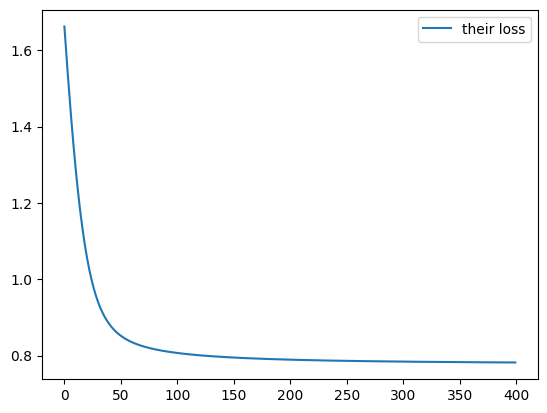

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

class DiffusionModel(nn.Module):
    def __init__(self):
        super(DiffusionModel, self).__init__()
        # self.fc1 = nn.Linear(in_features=GRID_SIZE*GRID_SIZE*NR_CHANNELS, out_features=3*NR_CHANNELS)
        # self.fc2 = nn.Linear(in_features=3*NR_CHANNELS, out_features=GRID_SIZE*GRID_SIZE*NR_CHANNELS)
        gs = my_dataset.grid_size
        nc = my_dataset.nr_channels
        self.fc1 = nn.Linear(in_features=gs*gs*nc, out_features=gs*gs*nc)
        self.final_activation_fn = nn.Sigmoid()
        # self.ReLU = nn.ReLU()

    def forward(self, x):
        output = self.fc1(x)
        # output = self.fc2(output)
        # output = self.ReLU(output)
        output = self.final_activation_fn(output)

        return output

model = DiffusionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 400

cost_arr = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for with_noise, without_noise in my_dataset:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(with_noise)

        loss = criterion(outputs, without_noise)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    if epoch % (num_epochs // 10) == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], cost={running_loss}')

    cost_arr.append(loss.item())

print('Training finished.')

plt.plot(cost_arr, label='their loss')
plt.legend()
plt.show()

# def visualize_model_perf(idx):

#     output = model(input)

    # picture_output = output.view(GRID_SIZE, GRID_SIZE, NR_CHANNELS)
    # visualize(dataset_outputs[idx], "ground_truth")
    # visualize(input.view(GRID_SIZE, GRID_SIZE, NR_CHANNELS), "noised input")
    # visualize(picture_output.detach(), "attempted denoise")

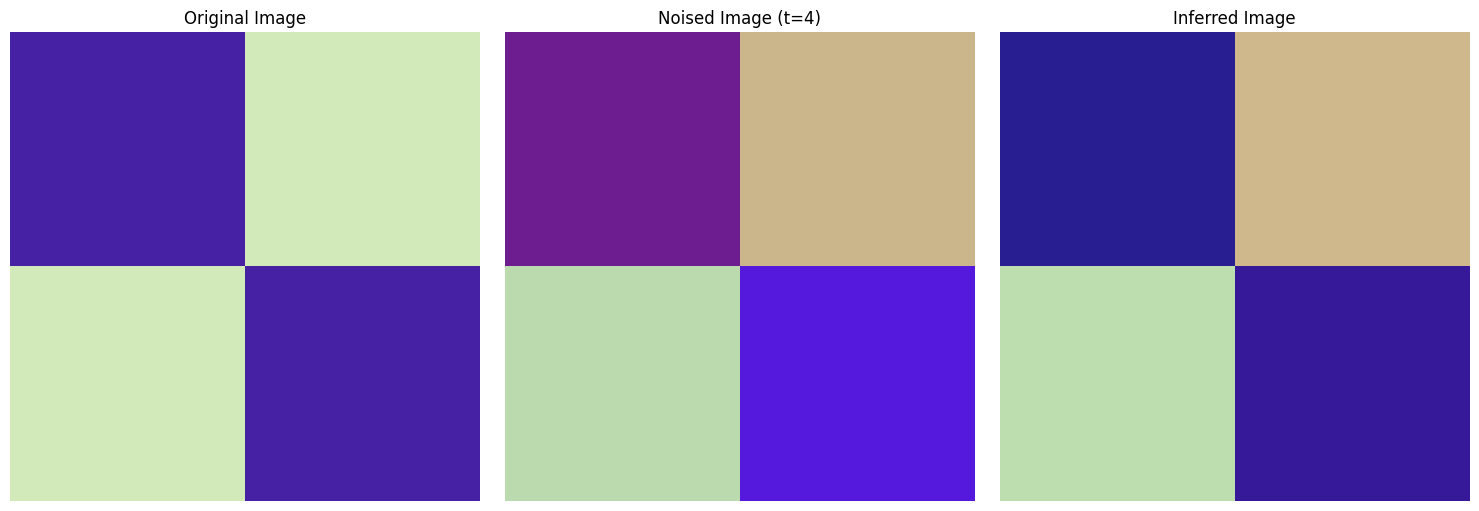

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [16]:
def get_beta_t(t : int):
    return my_dataset.beta_t # temp

def do_inference(noised_input : torch.tensor, T, model):
    model.eval()

    img = copy.deepcopy(noised_input)

    alpha_t_cum = 1

    with torch.no_grad():
        for i in range(T):
            alpha_t = 1 - get_beta_t(t)
            alpha_t_cum *= alpha_t

            c = (1 - alpha_t) / np.sqrt(1 - alpha_t_cum)
            random = torch.randn(img.shape) * get_beta_t(t)/20 # temp
            img = 1/np.sqrt(alpha_t) * (img - model(img) * c) + random
    
    model.train()

    return img

def visualize_inference(dataloader, model, T, sample_indices):
    if sample_indices == -1:
        sample_indices = [i for i in range(len(dataloader))]
    for i in sample_indices:

        input_with_noise, standard_gausian = my_dataset[i]
        original_img = my_dataset.get_original_img(i)
        time_step = my_dataset.t_arr[i]

        # Perform inference
        inferred_img = do_inference(input_with_noise, T, model)

        # Plot the images
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        gs, nc = my_dataset.grid_size, my_dataset.nr_channels
        
        axes[0].imshow(original_img.view(gs, gs, nc), vmin=0, vmax=1, interpolation='none')
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        axes[1].imshow(input_with_noise.view(gs, gs, nc), vmin=0, vmax=1, interpolation='none')
        axes[1].set_title(f'Noised Image (t={time_step})')
        axes[1].axis('off')
        
        axes[2].imshow(inferred_img.view(gs, gs, nc), vmin=0, vmax=1, interpolation='none')
        axes[2].set_title('Inferred Image')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()


# Example usage
visualize_inference(dataloader, model, T=T, sample_indices=-1)